# Lnaguage Changes

Group 5

- Alexander Bek, 
- Evelyn Birnzain,
- Eszter Iklódi,
- Anton Wohlgemuth

#### General questions of the task

- How does the use of various communication languages in countries change over time? 
- Which languages grow and which disappear, and what are their characteristics? 
- Are there other factors that correlate with the appearance or disappearance of languages?

#### Challenges of the task

- How to define extinction for languages? No native users? No one understands at all? 
- The ultimate historical data on language use of Ethnologue is way too expensive for a university project.
- There's a bias that there's more data for frequently used languages.

#### Restrictions

- Use only European data.
- Use data earliest from 1980s.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score

## Explore: Look into endangered languages data

(Eszter Iklódi)

#### Endangered languages

- https://www.kaggle.com/the-guardian/extinct-languages/version/1 (updated in 2016)
- original data: http://www.unesco.org/languages-atlas/index.php?hl=en&page=atlasmap (published in 2010)

#### Countries of the world

- https://www.ethnologue.com/sites/default/files/CountryCodes.tab

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/unesco_endangered_lang_europe.ipynb

#### First let's plot the distribution!

In [2]:
# https://www.kaggle.com/the-guardian/extinct-languages/version/1
df_end = pd.read_csv("data/endangerment/extinct_languages.csv")
df_end.head()

ID Name in English  Name in French      Name in Spanish  \
0  1022   South Italian  italien du sud  napolitano-calabrés   
1  1023        Sicilian        sicilien            siciliano   
2   383       Low Saxon       bas-saxon           bajo sajón   
3   335      Belarusian      biélorusse           bielorruso   
4   382         Lombard         lombard             lombardo   

                                           Countries  \
0                                              Italy   
1                                              Italy   
2  Germany, Denmark, Netherlands, Poland, Russian...   
3  Belarus, Latvia, Lithuania, Poland, Russian Fe...   
4                                 Italy, Switzerland   

          Country codes alpha 3  \
0                           ITA   
1                           ITA   
2       DEU, DNK, NLD, POL, RUS   
3  BRB, LVA, LTU, POL, RUS, UKR   
4                      ITA, CHE   

                                     ISO639-3 codes Degree of endangerment  \
0                                               nap             Vulnerable   
1                                               scn             Vulnerable   
2  act, drt, frs, gos, nds, sdz, stl, twd, vel, wep             Vulnerable   
3                                               bel             Vulnerable   
4                                               lmo  Definitely endangered   

                                     Alternate names Name in the language  \
0  Neapolitan; Neapolitan-Calabrese; неаполитанск...                  NaN   
1                                                NaN                  NaN   
2  Low German, Niedersächsisch, Nedersaksisch, Ni...       Neddersassisch   
3                                                NaN                  NaN   
4                                                NaN                  NaN   

   Number of speakers                                            Sources  \
0           7500000.0                                                NaN   
1           5000000.0                                                NaN   
2           4800000.0                                                NaN   
3           4000000.0  Hienadź Cychun: Weißrussisch. — Lexikon der Sp...   
4           3500000.0                                                NaN   

   Latitude  Longitude                        Description of the location  
0   40.9798    15.2490  Campania, Lucania (Basilicata), Abruzzi (Abruz...  
1   37.4399    14.5019  Sicily (Sicilia), southern and central Calabri...  
2   53.4029    10.3601  northern Germany, the north-eastern part of th...  
3   53.9560    27.5756  Belarus except the Polesian-speaking south-wes...  
4   45.7215     9.3273  the region of Lombardy (except the southernmos...

<AxesSubplot:>

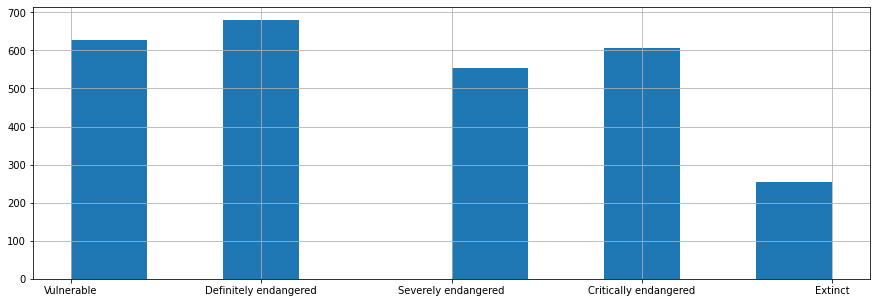

In [3]:
# Map textual degree of endangerment to numeric value
ENDANGERMENT_MAP = {
    "Vulnerable": 1,
    "Definitely endangered": 2,
    "Severely endangered": 3,
    "Critically endangered": 4,
    "Extinct": 5,
}
df_end["Endangerment code"] = df_end["Degree of endangerment"].apply(lambda x: ENDANGERMENT_MAP[x])
df_end["Degree of endangerment"].hist(figsize=(15,5))

#### Show languages on map

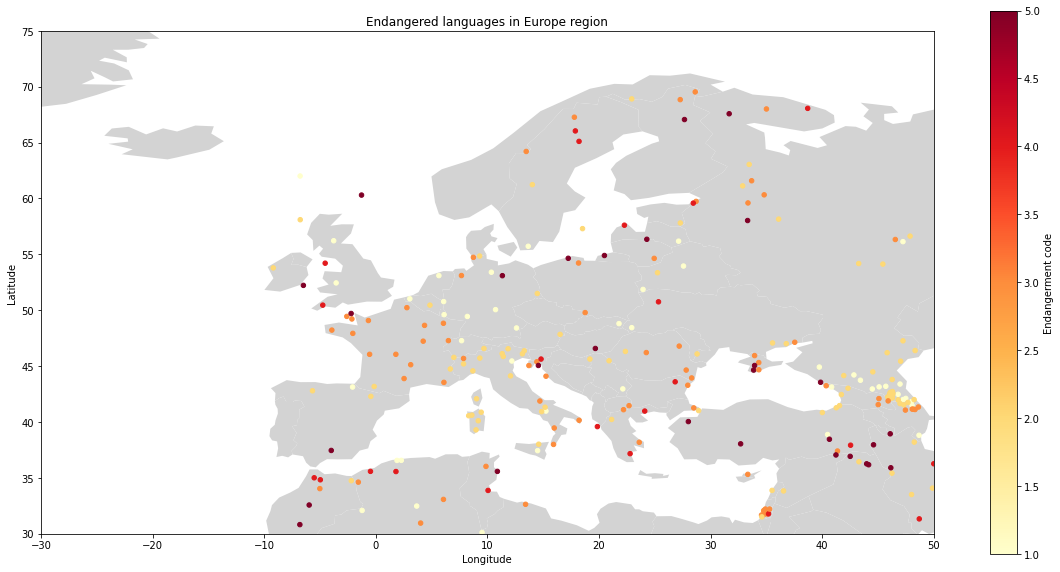

In [4]:
countries_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(20, 10))

# Plot Europe
countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_end.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="Endangered languages in Europe region", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

#### Filter European languages

In [5]:
# https://www.ethnologue.com/sites/default/files/CountryCodes.tab
countries = pd.read_csv("data/general/country_codes.tsv", sep="\t")
europe = countries[countries["Area"] == "Europe"]
europe_countries = set(europe["Name"].to_list())

# Clean data
df_end = df_end[df_end["Countries"].notna()]

# Filter
df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)
df_europe = df_end.loc[df_end["In Europe"] == True]

df_europe.head()

/tmp/ipykernel_17564/2900314512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)


ID Name in English  Name in French      Name in Spanish  \
0  1022   South Italian  italien du sud  napolitano-calabrés   
1  1023        Sicilian        sicilien            siciliano   
2   383       Low Saxon       bas-saxon           bajo sajón   
3   335      Belarusian      biélorusse           bielorruso   
4   382         Lombard         lombard             lombardo   

                                           Countries  \
0                                              Italy   
1                                              Italy   
2  Germany, Denmark, Netherlands, Poland, Russian...   
3  Belarus, Latvia, Lithuania, Poland, Russian Fe...   
4                                 Italy, Switzerland   

          Country codes alpha 3  \
0                           ITA   
1                           ITA   
2       DEU, DNK, NLD, POL, RUS   
3  BRB, LVA, LTU, POL, RUS, UKR   
4                      ITA, CHE   

                                     ISO639-3 codes Degree of endangerment  \
0                                               nap             Vulnerable   
1                                               scn             Vulnerable   
2  act, drt, frs, gos, nds, sdz, stl, twd, vel, wep             Vulnerable   
3                                               bel             Vulnerable   
4                                               lmo  Definitely endangered   

                                     Alternate names Name in the language  \
0  Neapolitan; Neapolitan-Calabrese; неаполитанск...                  NaN   
1                                                NaN                  NaN   
2  Low German, Niedersächsisch, Nedersaksisch, Ni...       Neddersassisch   
3                                                NaN                  NaN   
4                                                NaN                  NaN   

   Number of speakers                                            Sources  \
0           7500000.0                                                NaN   
1           5000000.0                                                NaN   
2           4800000.0                                                NaN   
3           4000000.0  Hienadź Cychun: Weißrussisch. — Lexikon der Sp...   
4           3500000.0                                                NaN   

   Latitude  Longitude                        Description of the location  \
0   40.9798    15.2490  Campania, Lucania (Basilicata), Abruzzi (Abruz...   
1   37.4399    14.5019  Sicily (Sicilia), southern and central Calabri...   
2   53.4029    10.3601  northern Germany, the north-eastern part of th...   
3   53.9560    27.5756  Belarus except the Polesian-speaking south-wes...   
4   45.7215     9.3273  the region of Lombardy (except the southernmos...   

   Endangerment code  In Europe  
0                  1       True  
1                  1       True  
2                  1       True  
3                  1       True  
4                  2       True

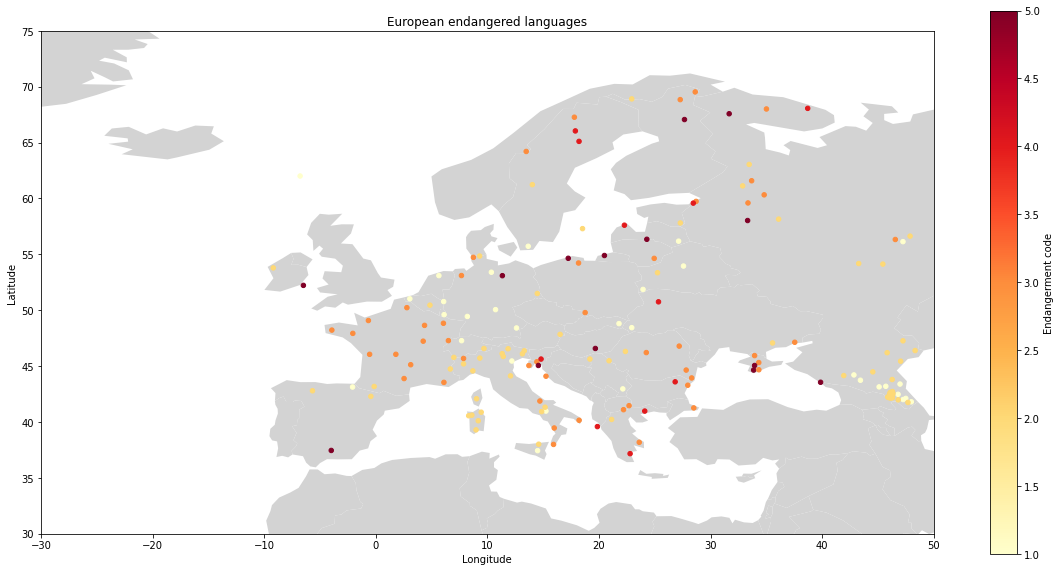

In [6]:
# Plot only European endangered languages
fig, ax = plt.subplots(figsize=(20, 10))

countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_europe.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="European endangered languages", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

## Question 1: Which digital resources are the most important for the survival of a language?

(Eszter Iklódi)

### Data

#### Digital Language Death

Paper (2012): https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077056  
Data: http://hlt.sztaki.hu/resources/  
Data description: http://hlt.sztaki.hu/resources/dld-header.pdf  
Online version: https://hlt.bme.hu/en/dld/  

#### Crúbadán project

DLD data uses the Crúbadán crawls. The aim of this project is the creation of text corpora for a large number of under-resourced languages by crawling the web. It supports more than 2000 languages.

Paper (2007): https://cs.slu.edu/~scannell/pub/wac3.pdf  
Project website: http://crubadan.org/

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/dld_european_lang.ipynb

#### Prepare data

In [7]:
# http://hlt.sztaki.hu/resources/dld-joined.tsv
dld = pd.read_csv("data/digital/dld_joined.tsv", sep="\t", skiprows=2, low_memory=False)

LANG_ID = "LangID"

######################
# Columns of interest
######################

# Ids & Names
PRINT_NAME = "Print_Name" # standardized English language name
LANG_LOC = "language (local)" # the local name of the language
SIL = "SIL code" # SIL code

# Endangerment status
ETHN = "Eth_Language Status" # the EGIDS status of the language according to the Ethnologue.
ELP = "end_class" # classification according to the Endangered Languages Project (the higher, the more endangered)

# Speakers
L1 = "L1" # number of people speaking the language natively (L1 speakers)
L2 = "L2" # number of people speaking the language as second language (L2 speakers)

# Wikipedia
WP_NAME = "wikiname" # the two-letter (sometimes longer) code used in Wikipedia
WP_ART = "articles" # number of articles in wikipedia (2012 May)
WP_SIZE_ADJ = "adjusted WP size" # character count of ‘real’ wikipedia pages
WP_SIZE_CH = "WP size in chars" # raw (unadjusted) character count of wikipedia
WP_INCUB = "WP_incubator_new" # whether Wikipedia had an incubator for the language in March 2013
WP_AVG_LEN = "avg good page length" # average length of ‘real’ wikipedia pages
WP_REAL_TOT = "real/ total ratio" #  proportion of ‘real’ and 'total' wikipedia pages

# Windows
MS_IN = "MS-if-pack" # Microsoft input-level support
MS_OS = "MS-pack" # OS-level support in Windows 7

# MAC
MAC_IN = "MAC-input" # input-level support by Apple
MAC_OS = "MAC-supp" # OS-level support in MacOS 10.6.8

# Spellchecker
HUN_STAT = "hunspell status" # whether a hunspell checker exists
HUN_COV = "hunspell coverage" # the percentage coverage Hunspell has on the wikipedia dump

# Crúbadán
CR1_ID = "cru1_ISO-639-3" # iso-code from first Crúbadán summary
CR2_ID = "cru2_ISO-639-3" # iso-code from second Crúbadán summary

CR1_CH = "cru1_Characters" # number of characters found by the first Crúbadán crawl
CR2_CH = "cru2_Characters" # number of characters found by the second Crúbadán crawl

CR1_WORDS = "cru1_Words" # number of words found by the first Crúbadán crawl
CR2_WORDS = "cru2_Words" # number of words found by the second Crúbadán crawl

CR1_DOCS = "cru1_Docs" # number of documents found by the first Crúbadán crawl
CR2_DOCS = "cru2_Docs" # number of documents found by the second Crúbadán crawl

CR1_UDHR = "cru1_UDHR" # translation of the Universal Declaration of Human rights exists according to the first Crúbadán summary
CR2_UDHR = "cru2_UDHR" # translation of the Universal Declaration of Human rights exists according to the second Crúbadán summary

CR1_FLOSS = "cru1_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the first Crúbadán summary
CR2_FLOSS = "cru2_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the second Crúbadán summary

CR1_BIB = "cru1_WT" # whether an online Bible exists at watchtower.org according to the first Crúbadán summary
CR2_BIB = "cru2_WT" # whether an online Bible exists at watchtower.org according to the second Crúbadán summary

# Other
TLD = "TLDs(%)" # whether a national level Top Level Domain (not .com, .org, .edu) appeared in the top three domains that the crawl found language data in
OLAC = "la_Primary texts_Online" # the number of OLAC primary texts online

In [8]:
# Filter columns of interest

dld_fil = dld[[
    # Ids & names
    PRINT_NAME,
    LANG_LOC,
    SIL,    
    
    # Endangerment status
    ETHN,
    ELP,
    
    # Speakers
    L1,
    L2,
    
    # Wikipedia
    WP_NAME,
    WP_ART,
    WP_SIZE_ADJ,
    WP_SIZE_CH,
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    
    # Windows
    MS_IN,
    MS_OS,
    
    # MAC
    MAC_IN,
    MAC_OS,
    
    # Spellchecker
    HUN_STAT,
    HUN_COV,
    
    # Crúbadán
    CR1_ID,
    CR2_ID,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    
    # Other
    TLD,
    OLAC
]]

dld_fil.head()

Print_Name language (local) SIL code  Eth_Language Status  \
0                   0                0        0                  7.7   
1             Tawandê                0        0                  8.0   
2               Thawa                0        0                 10.0   
3  Cuyamecalco Mixtec                0        0                  6.5   
4      Tacahua Mixtec                0        0                  6.5   

   end_class    L1  L2 wikiname  articles  adjusted WP size  ...  cru1_Docs  \
0          7     0   0        0         0               0.0  ...          0   
1          8     0   0        0         0               0.0  ...          0   
2          0     0   0        0         0               0.0  ...          0   
3          0  1880   0        0         0               0.0  ...          0   
4          0   390   0        0         0               0.0  ...          0   

   cru2_Docs  cru1_UDHR  cru2_UDHR  cru1_FLOSS SplChk cru2_FLOSS SplChk  \
0          0          0          0                  0                 0   
1          0          0          0                  0                 0   
2          0          0          0                  0                 0   
3          0          0          0                  0                 0   
4          0          0          0                  0                 0   

   cru1_WT cru2_WT TLDs(%)  la_Primary texts_Online  
0        0       0       0                        0  
1        0       0       0                        0  
2        0       0       0                        0  
3        0       0       0                        0  
4        0       0       0                        0  

[5 rows x 36 columns]

#### Filter for Europe

In [9]:
# Output of https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/ethnologue_lang_europe.ipynb
eur_lang = pd.read_csv("data/general/european_languages.csv")

eur_dld = eur_lang.join(dld_fil.set_index(CR2_ID), on="LangID", how="inner")
eur_dld.head()

LangID CountryID LangStatus            Name_lang Name_country    Area  \
0    aae        IT          L  Albanian, Arbëreshë        Italy  Europe   
3    fur        IT          L             Friulian        Italy  Europe   
6    ita        IT          L              Italian        Italy  Europe   
8    lij        IT          L             Ligurian        Italy  Europe   
9    lld        IT          L                Ladin        Italy  Europe   

           Print_Name language (local) SIL code  Eth_Language Status  ...  \
0  Arbëreshë Albanian                0        0                  6.5  ...   
3            Friulian           Furlan      fur                  5.0  ...   
6             Italian         Italiano      ita                  1.0  ...   
8            Ligurian           Líguru      lij                  5.0  ...   
9               Ladin                0        0                  6.5  ...   

   cru1_Docs cru2_Docs  cru1_UDHR cru2_UDHR  cru1_FLOSS SplChk  \
0          1         0          -         -                 no   
3       8926         0        frl       frl                yes   
6       1212         0        itn       itn                yes   
8         40         0          -         -                 no   
9        399         0          -         -                 no   

   cru2_FLOSS SplChk  cru1_WT  cru2_WT                   TLDs(%)  \
0                 no        -        -                         0   
3                yes        -        -  37.20 o 20.59 it 15.89 c   
6                yes        i        i  27.57 o 24.86 it 23.21 c   
8                 no        -        -  32.46 o 15.15 it 14.52 c   
9                 no       rh       rh                         0   

   la_Primary texts_Online  
0                        0  
3                        0  
6                       22  
8                        0  
9                        0  

[5 rows x 41 columns]

#### Clean data

In [10]:
eur_dld_clean = eur_dld.copy()

# L1 is interpreted as object -> convert to int
eur_dld_clean[L1] = eur_dld[L1].astype(int)

# MAC OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_mac(x):
    if x == "TRUE":
        return 1
    return 0

eur_dld_clean[MAC_OS] = eur_dld[MAC_OS].apply(lambda x: apply_mac(x))

# Microsoft OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_win(x):
    if x == "P" or x == "F":
        return 1
    return 0

eur_dld_clean[MS_OS] = eur_dld[MS_OS].apply(lambda x: apply_win(x))

# UDHR and Bible availability is given textual -> convert it to 0/1 (if there's any it's 1)
def true_id_not_empty(x):
    if x == "-":
        return 0
    return 1

eur_dld_clean[CR1_UDHR] = eur_dld[CR1_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_UDHR] = eur_dld[CR2_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR1_BIB] = eur_dld[CR1_BIB].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_BIB] = eur_dld[CR2_BIB].apply(lambda x: true_id_not_empty(x))

# FLOSS availability is given textual -> convert it to 0/1 (no data is also 0)
def apply_floss(x):
    if x == "yes":
        return 1
    return 0

eur_dld_clean[CR1_FLOSS] = eur_dld[CR1_FLOSS].apply(lambda x: apply_floss(x))
eur_dld_clean[CR2_FLOSS] = eur_dld[CR2_FLOSS].apply(lambda x: apply_floss(x))

# Fill NaN with 0
eur_dld_clean[MS_IN] = eur_dld[MS_IN].fillna(0)
eur_dld_clean[HUN_COV] = eur_dld[HUN_COV].fillna(0)

#### Investigate correlation

<AxesSubplot:title={'center':'Correlation between numeric variables'}>

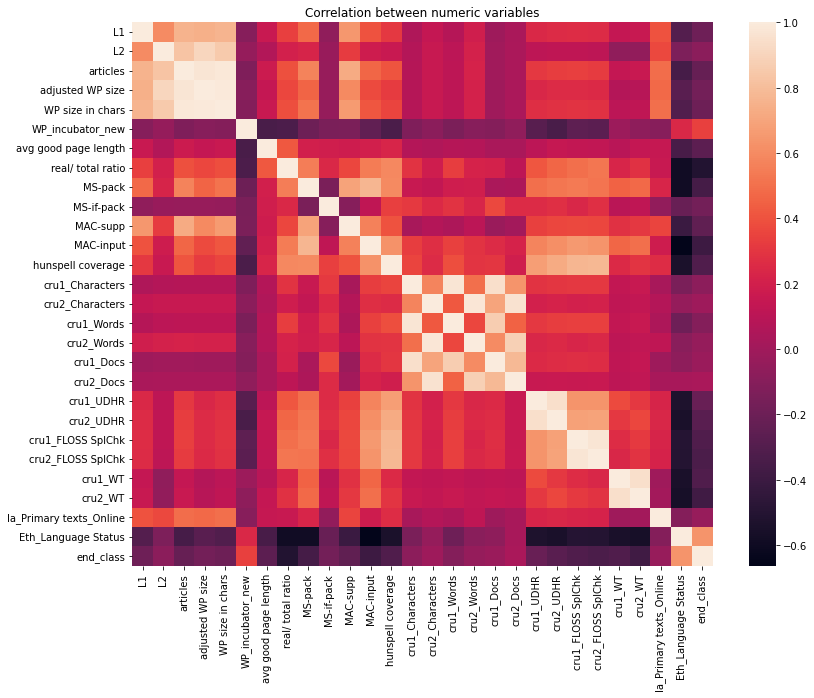

In [11]:
# Columns with numerical values
NUM_COLS = [
    L1,
    L2,
    WP_ART,
    WP_SIZE_ADJ, 
    WP_SIZE_CH, 
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    MS_OS,
    MS_IN,
    MAC_OS,
    MAC_IN,
    HUN_COV,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    OLAC
]

STATUS_COLS = [
    ETHN,
    ELP,
]

# Correlation matrix of numerical values
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation between numeric variables")
corr = eur_dld_clean[NUM_COLS + STATUS_COLS].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:title={'center':'Enthologue status'}, xlabel='LangID'>

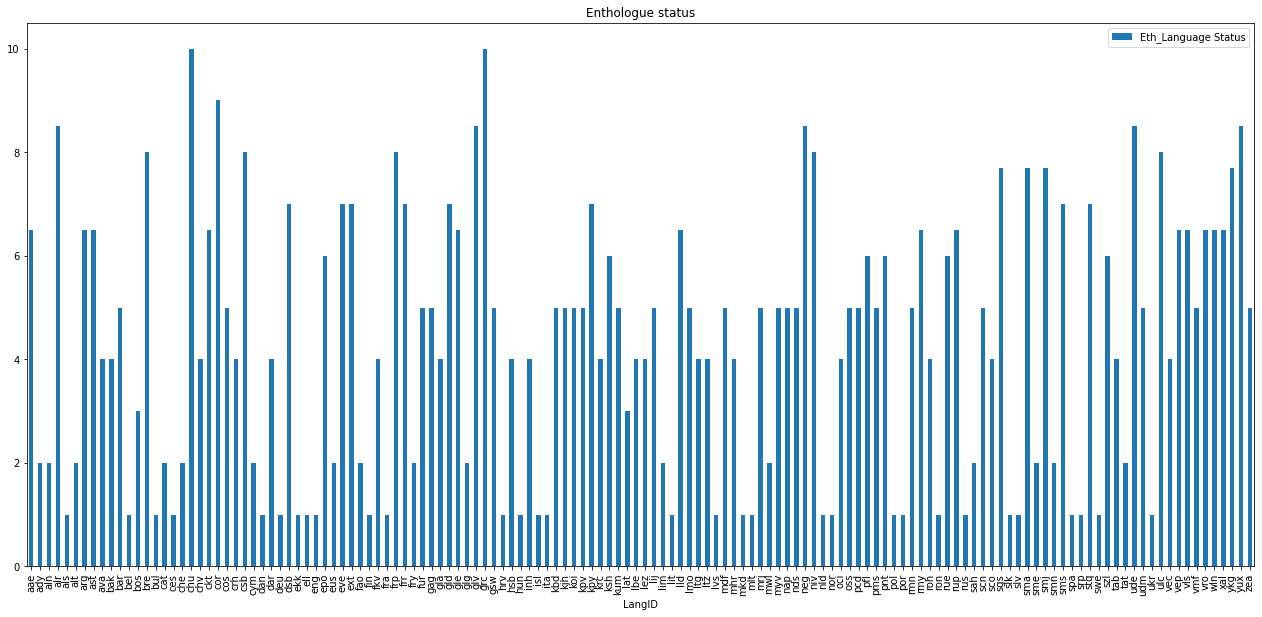

In [12]:
# Correlation with endangerment status of Ethnologue
eur_dld_clean.set_index(LANG_ID).sort_index().plot(y=ETHN, figsize=(22, 10), title="Enthologue status", kind="bar")

Eth_Language Status
MAC-input                          -0.663741
real/ total ratio                  -0.590073
MS-pack                            -0.587607
cru2_WT                            -0.566121
cru1_WT                            -0.548833
cru2_UDHR                          -0.546941
hunspell coverage                  -0.544136
cru1_UDHR                          -0.529287
cru2_FLOSS SplChk                  -0.502468
cru1_FLOSS SplChk                  -0.495520
MAC-supp                           -0.405487
articles                           -0.352606
avg good page length               -0.349439
WP size in chars                   -0.310360
L1                                 -0.294537
adjusted WP size                   -0.278370
MS-if-pack                         -0.216036
cru1_Words                         -0.192093
cru1_Characters                    -0.145836
L2                                 -0.130887
la_Primary texts_Online            -0.108014
cru2_Words                         -0.088166
cru1_Docs                          -0.066773
cru2_Characters                    -0.043228
cru2_Docs                           0.025223
WP_incubator_new                    0.244965
end_class                           0.630148
Eth_Language Status                 1.000000

<AxesSubplot:title={'center':'Correlation with degree and availability of digital tools - Ethnologue'}>

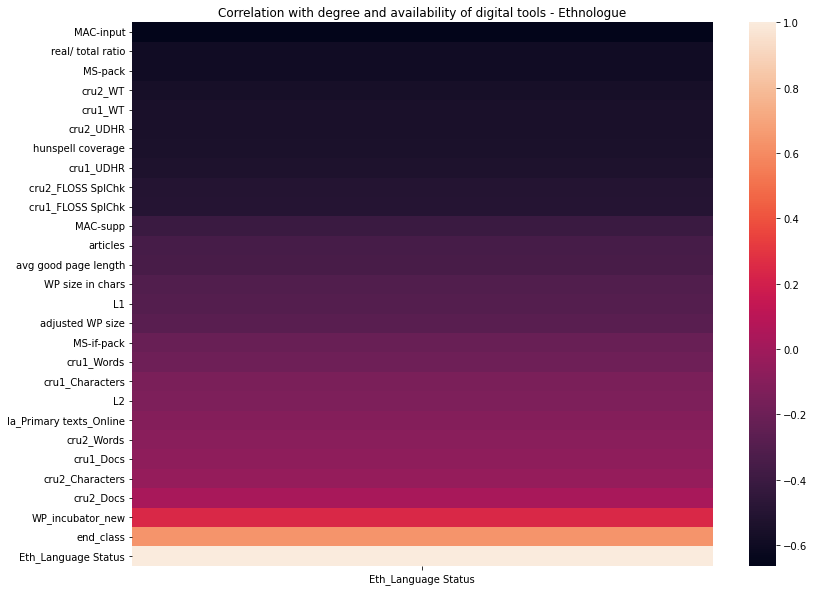

In [13]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation with degree and availability of digital tools - Ethnologue")

corr_ethn = corr[[ETHN]].sort_values(by=ETHN)
display(corr_ethn)
sns.heatmap(corr_ethn, 
        xticklabels=corr_ethn.columns,
        yticklabels=corr_ethn.index)

#### Fit model to find out most important factors

In [14]:
def create_dataset(data, label_to_predict, test_size=0.2, random_state=0):
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)

    y = train[label_to_predict]
    y_true = test[label_to_predict]

    del train[label_to_predict]
    del test[label_to_predict]
    return train, test, y, y_true

def print_pred(y_true, y_pred, title):
    df = pd.DataFrame()
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df.sort_index().plot(y=["y_true", "y_pred"], figsize=(22, 10), title=title, kind="bar")
    
def print_coefs(cols, coefs):
    df = pd.DataFrame()
    df["Features"] = cols
    df["coefs"] = abs(coefs)
    display(df.sort_values(by="coefs", ascending=False))
    
def print_score(y_true, y_pred, method):
    print(method(y_true, y_pred))

def fit(scaler, model, train, y, test, y_true, coefs=False, title=None):
    reg = make_pipeline(scaler, model)
    reg.fit(train, y)
    y_pred = reg.predict(test)
    print_score(y_true, y_pred, explained_variance_score)
    if coefs:
        print_coefs(train.columns, model.coef_)
    if title:
        print_pred(y_true, y_pred, title)
    return y_pred

In [15]:
# Create dataset
data = eur_dld_clean[NUM_COLS + [ETHN, LANG_ID]]
data.set_index("LangID", inplace=True)
train, test, y, y_true = create_dataset(data, ETHN, test_size=0.2, random_state=0)

-4.3965354501857705


Features         coefs
10                 MAC-supp  5.072919e+08
11                MAC-input  2.110703e+08
8                   MS-pack  1.708168e+08
9                MS-if-pack  3.701979e+07
21        cru1_FLOSS SplChk  1.334710e+07
12        hunspell coverage  1.227116e+07
7         real/ total ratio  8.289368e+06
22        cru2_FLOSS SplChk  7.480005e+06
20                cru2_UDHR  2.953604e+05
23                  cru1_WT  1.933459e+05
19                cru1_UDHR  1.832151e+05
24                  cru2_WT  8.120054e+04
5          WP_incubator_new  1.848467e+04
25  la_Primary texts_Online  1.689118e+04
17                cru1_Docs  1.589555e+04
2                  articles  7.622130e+02
18                cru2_Docs  5.101612e+02
6      avg good page length  2.861254e+02
16               cru2_Words  3.257594e+01
15               cru1_Words  9.649112e+00
3          adjusted WP size  5.680639e+00
14          cru2_Characters  4.782926e+00
1                        L2  1.098972e+00
0                        L1  3.243025e-01
13          cru1_Characters  1.610018e-01
4          WP size in chars  1.553657e-01

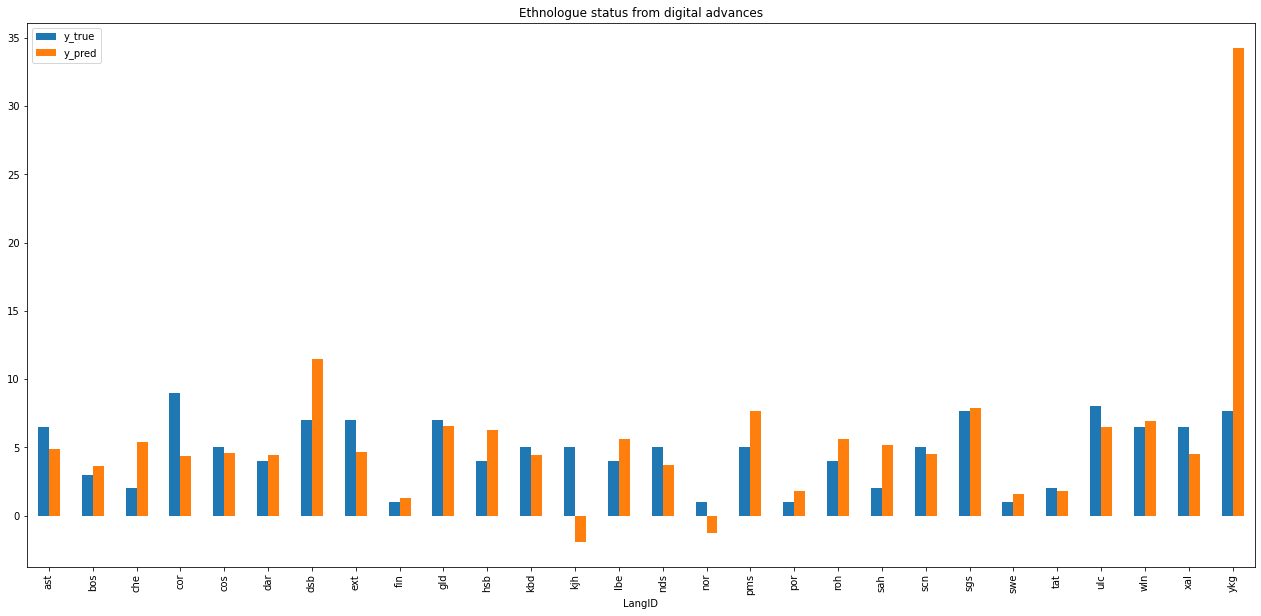

In [16]:
# Fit model
lr = LinearRegression()
y_pred_lr = fit(Normalizer(), lr, train, y, test, y_true, coefs=True, title="Ethnologue status from digital advances")

#### Conslusion

Most important digitalization factors for determining endangerment status:

- MAC and Windows OS level & input support
- The existence of a spellchecker and their word coverage.
- Ratio of real/total wikipedia pages.
- Availability of Bible and Universal Declaration of Human rights translations


Not so important featrues (for both metrics):

- Number of speakers.
- Character size of available resources.